# Path Finding Algorithm
## Find strongest path with thpt

In [33]:
pip install osmnx

In [34]:
# from pyrosm import OSM
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import folium
import heapq

# ## 사용함수 정의 ##
# 도로 네트워크 생성 함수 정의(ver1)
def fetch_campus_map(place_name="Chungbuk National University"):
    """
    캠퍼스의 OSM 데이터를 가져와서 도로 네트워크를 생성하는 함수.

    - place_name: 지도에서 검색할 위치 (캠퍼스 이름 등)

    반환: 캠퍼스 도로 네트워크 그래프
    """
    # 주어진 위치를 기준으로 도로 네트워크를 다운로드
    G = ox.graph_from_place(place_name, network_type="walk")  # 도보 네트워크 기준
    return G

#  출발지 및 목적지 노드 설정 함수 정의
def get_nearest_node(G, latitude, longitude):
    """
    입력된 위도와 경도에 가장 가까운 그래프 노드를 찾는 함수.

    - G: 도로 네트워크 그래프
    - latitude: 위도
    - longitude: 경도

    반환: 가장 가까운 노드 ID
    """
    return ox.distance.nearest_nodes(G, longitude, latitude)

# 최단 경로 탐색 함수 정의
def find_shortest_path(G, origin_point, destination_point):
    """
    입력된 출발지와 목적지 간 최단 경로를 찾는 함수.

    - G: 도로 네트워크 그래프
    - origin_point: 출발지 좌표 (위도, 경도)
    - destination_point: 목적지 좌표 (위도, 경도)

    반환: 최단 경로 노드 리스트
    """
    # # 출발지와 목적지의 가장 가까운 노드 찾기
    # origin_node = get_nearest_node(G, *origin_point)
    # destination_node = get_nearest_node(G, *destination_point)

    # 최단 경로 계산 (Dijkstra 알고리즘)
    shortest_path = nx.shortest_path(G, origin_point, destination_point, weight='length',method="dijkstra") #
    return shortest_path


# 경로 시각화 함수 정의
def plot_route(G, path):
    """
    최단 경로를 그래프에 시각화하는 함수.

    - G: 도로 네트워크 그래프
    - path: 최단 경로 노드 리스트
    """
    fig, ax = ox.plot_graph_route(G, path, route_linewidth=2, node_size=0, bgcolor='k')
    plt.show()

# 도로만 남기는 함수
def create_filtered_graph(G, excluded_highway_types):
    """
    특정 highway 유형을 제외한 새로운 그래프를 반환하는 함수.

    - G: NetworkX 그래프
    - excluded_highway_types: 제외할 highway 유형 리스트 (예: ['footway'])

    반환: 제외된 엣지가 제거된 새로운 NetworkX 그래프
    """
    # 그래프 복사 (원본을 유지하기 위해)
    filtered_graph = G.copy()

    # 제거 대상 엣지 식별 및 제거
    edges_to_remove = [
        (u, v) for u, v, data in filtered_graph.edges(data=True)
        if data.get('highway') in excluded_highway_types
    ]
    filtered_graph.remove_edges_from(edges_to_remove)

    # print(f"Removed {len(edges_to_remove)} edges with highway types: {excluded_highway_types}")
    return filtered_graph

# 도로 네트워크 시각화 함수 정의 (Node ID 표시 추가) - 추가기능
def plot_campus_map_with_node_ids(G, poi_coords=None):
    """
    캠퍼스 도로 네트워크와 각 노드의 ID를 시각화하는 함수.

    - G: 도로 네트워크 그래프
    - poi_coords: POI 위치 좌표 리스트 (선택적)
    """
    # 도로 네트워크 시각화
    fig, ax = ox.plot_graph(G, show=False, close=False)

    i = 1
    # 각 노드의 위치에 Node ID를 표시
    for node, data in G.nodes(data=True):
        x, y = data['x'], data['y']
        if node == 4727599759 or node == 4403782482:
            ax.text(x, y, str(node), fontsize=8, color='blue')  # Node ID 표시

    # POI 위치 시각화 (있을 경우)
    if poi_coords:
        y, x = zip(*poi_coords)
        ax.scatter(x, y, c='red', s=30, label='POI')
        ax.legend()

    plt.show()

# throughput 데이터를 노드에 매핑하는 함수 정의
def map_pathloss_to_nodes(G, pathloss_df):
    """
    Pathloss 데이터를 그래프 노드 속성으로 매핑하는 함수.

    - G: 도로 네트워크 그래프
    - pathloss_df: 노드 ID와 pathloss 값을 가진 DataFrame

    반환: pathloss 속성이 추가된 그래프
    """
    for node, data in G.nodes(data=True):
        pathloss_value = pathloss_df.loc[pathloss_df['Node ID'] == node, 'Throughput (Mbps)'].values
        if len(pathloss_value) > 0:
            G.nodes[node]['throughput'] = pathloss_value[0]  # pathloss 값을 노드에 추가
        else:
            G.nodes[node]['throughput'] = None  # 데이터가 없을 경우 None
    return G

# 간선 가중치를 throughput 값으로 설정하는 함수 정의
def set_edge_weights_based_on_pathloss(G):
    """
    간선의 가중치를 두 노드의 pathloss 값의 평균으로 설정하는 함수.

    - G: 도로 네트워크 그래프

    반환: 가중치가 추가된 그래프
    """
    for u, v, data in G.edges(data=True):
        pathloss_u = G.nodes[u].get('throughput')
        pathloss_v = G.nodes[v].get('throughput')
        if pathloss_u is not None and pathloss_v is not None:
            data['throughput'] = 1 / ((pathloss_u + pathloss_v) / 2) # 평균 throughput의 역수를 가중치로 설정
        else:
            data['throughput'] = float('inf')  # throughput 값이 없으면 매우 큰 값으로 설정, 1/throughput = inf, throughput = 0
    return G



# osm 지도에 route 표시하는 함수
def plot_route_on_map(G, path, map_center=(36.624683, 127.463406), map_zoom=15):
    """
    Folium을 사용하여 경로를 지도에 표시하는 함수.

    - G: NetworkX 그래프
    - path: 경로에 포함된 노드 리스트
    - map_center: 지도의 중심 좌표 (위도, 경도)
    - map_zoom: 지도의 줌 레벨
    """
    # Folium 지도 생성
    route_map = folium.Map(location=map_center, zoom_start=map_zoom)

    # 경로의 좌표 추출
    route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for e in path]

    # 경로를 PolyLine으로 지도에 추가
    folium.PolyLine(route_coords, color="blue", weight=5, opacity=0.8).add_to(route_map)

    # 경로의 시작점과 끝점을 표시
    folium.Marker(route_coords[0],
                popup="Start",
                icon=folium.Icon(icon = 'car',color="green",prefix='fa')).add_to(route_map)
    folium.Marker(route_coords[-1], popup="End", icon=folium.Icon(icon = 'car',color="red",prefix='fa')).add_to(route_map)

    # 지도 반환
    return route_map


# thpt을 가중치로 하여 신호 세기가 강한 경로를 찾는 알고리즘 함수 생성

In [35]:
# ★ Custom 알고리즘 추가 ★
def find_strongest_path(G, source, target, weight = 'throughput'):
    """
    Dijkstra 알고리즘을 수정하여 평균 가중치를 고려한 경로를 찾는 함수.

    - G: NetworkX 그래프
    - source: 출발 노드
    - target: 도착 노드
    - weight: 간선의 가중치를 나타내는 속성 ("pathloss" 등)

    반환:
    - 최단 경로의 노드 리스트
    - 경로의 평균 가중치
    """
    # 우선순위 큐 초기화
    queue = [(0, 0, 0, source, [])]  # (평균 가중치, 누적 가중치, 간선 수, 현재 노드, 경로)
    visited = set()

    while queue:
        avg_weight, cum_weight, num_edges, current_node, path = heapq.heappop(queue)

        # 이미 방문한 노드는 무시
        if current_node in visited:
            continue
        visited.add(current_node)

        # 현재 노드를 경로에 추가
        path = path + [current_node]

        # 목표 노드에 도달하면 결과 반환
        if current_node == target:
            return path, avg_weight

        # 인접 노드 탐색
        for neighbor in G.neighbors(current_node):
            edge_data = G[current_node][neighbor]

            # 다중 간선 처리 - 최소 가중치 선택
            min_edge_weight = float('inf')  # 초기값을 무한대로 설정
            for key, data in edge_data.items():
                edge_weight = data.get(weight)  # 'weight' 속성 참조
                if edge_weight is None:
                    continue  # 가중치 없는 간선은 무시
                min_edge_weight = min(min_edge_weight, edge_weight)  # 최소 가중치 추적

            # 최소 가중치를 기반으로 경로 확장
            if min_edge_weight < float('inf'):  # 유효한 간선이 있는 경우
                new_cum_weight = cum_weight + min_edge_weight
                new_num_edges = num_edges + 1
                new_avg_weight = new_cum_weight / new_num_edges

                # 우선순위 큐에 추가
                heapq.heappush(queue, (new_avg_weight, new_cum_weight, new_num_edges, neighbor, path))

    # 목표 노드에 도달하지 못한 경우
    return None, float('inf')

- 충북대 osm 불러오기 및 src, target 지정

In [36]:
## 실행코드 ##
## strongest 경로 찾기
# file_path = "cbnu.osm"  # .osm 파일 경로
place_name = "Chungbuk National University"  # 추출할 영역 이름

# 충북대학교 지도 데이터 가져오기
campus_graph = fetch_campus_map(place_name)

# 출발지 및 목적지 좌표 설정 (충북대학교 내부의 임의 좌표)
origin = (36.624683, 127.463406)  # 충북대학교 후문 근처
destination = (36.6315694, 127.4533229)  # 충북대학교 정문 근처 127.4533229!2d36.6315694

# 출발지와 목적지의 가장 가까운 노드 찾기
origin_node = get_nearest_node(campus_graph, *origin)
destination_node = get_nearest_node(campus_graph, *destination)


- 최단 경로 탐색

[4727599759, 4496854212, 4727599754, 4658272910, 4658272907, 4658272627, 4658272625, 4658272616, 4403766754, 4727599752, 4403766719, 4400580281, 4658272841, 4727599749, 4400580283, 4403766738, 4748297939, 4658272899, 4400580266, 4658272691, 6089623942, 6089623939, 6089623938, 4404202948, 4404203098, 4404202986, 4404203097, 4404202957, 4404202949, 4404203151, 4404203152, 4404203156, 4402724109, 4655492812, 4402724117, 4404203164, 4402724105, 4727599724, 4402724104, 3958352394, 4727599721, 4748296088, 4748296080]


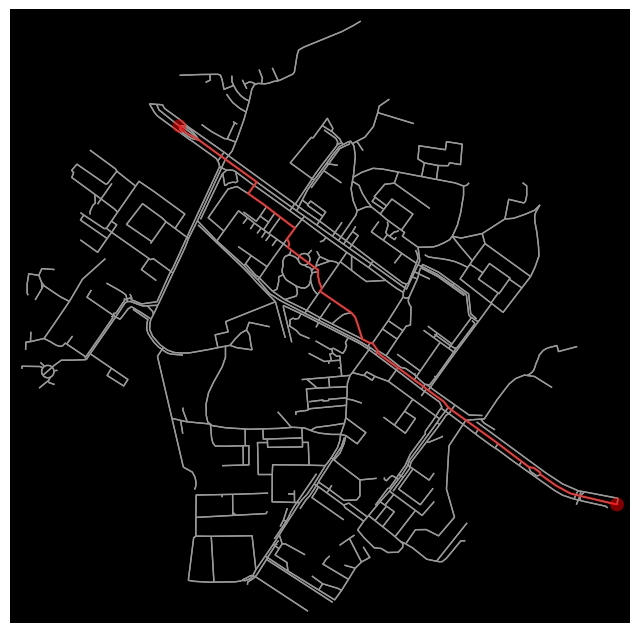

In [37]:
# 최단 경로 탐색
# 다익스트라 : shortest_path = find_shortest_path(campus_graph, origin_node, destination_node)
shortest_path = find_astar_path(campus_graph, origin_node, destination_node)
print(shortest_path)

# 최단 경로 시각화
plot_route(campus_graph, shortest_path)

# 최단 경로의 가중치 합 계산 (길이 [단위 : m])
shortest_path_length = nx.shortest_path_length(campus_graph, origin_node, destination_node, weight='length')

# 최단 경로를 거치는 모든 노드 수
num_nodes_in_path = len(shortest_path)

In [38]:
print("before")
# 필터링 전 캠퍼스 도로 네트워크 정보 출력
print(f"총 노드 수 : {len(campus_graph.nodes(data=True))}")
print(f"총 경로 수 : {len(campus_graph.edges(data=True))}")

# 필터링 전 최단 경로 정보 출력
print(f"최단 경로의 가중치 합 (길이): {shortest_path_length}m")
print(f"최단 경로에서 거치는 노드의 수: {num_nodes_in_path} 개")

before
총 노드 수 : 594
총 경로 수 : 1542
최단 경로의 가중치 합 (길이): 1251.4530239732278m
최단 경로에서 거치는 노드의 수: 43 개


- 도보 재외 네트워크 만들기 (한 번 더 확인해야 함.)
    - footway를 제거한 경로가 차도가 맞는지 확인 필요

In [39]:
## 도보 제외한 네트워크 Graph 생성
# 제외할 highway 유형 설정
excluded_highways = ['footway']

# 필터링된 그래프 생성
filtered_graph = create_filtered_graph(campus_graph, excluded_highways)

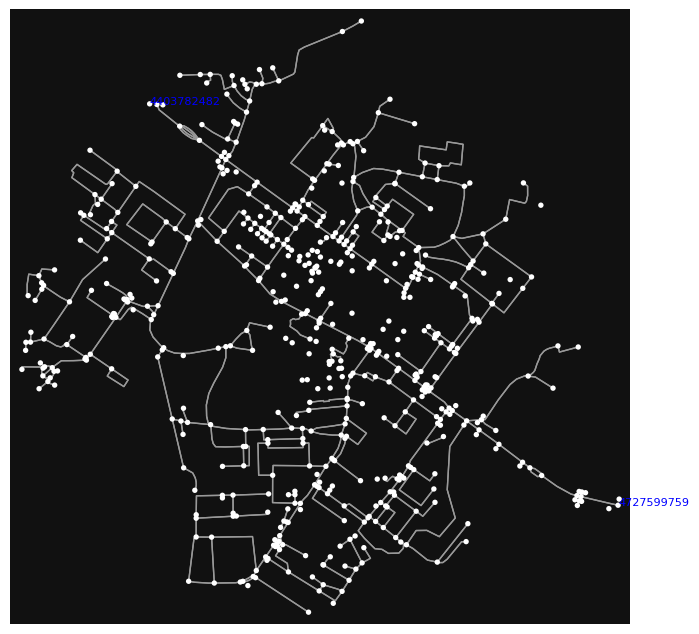

In [40]:
plot_campus_map_with_node_ids(filtered_graph)

- 도보를 제거한 네트워크(graph)에서 최단 경로 확인

[4727599759, 4496854212, 4727599754, 4658272910, 4658272907, 4658272627, 4658272625, 4658272616, 4403766754, 4727599752, 4403766719, 4400580281, 4658272841, 4727599749, 4400580283, 4403766738, 4748297939, 3958352374, 4748267385, 6089623937, 4400580244, 3958352384, 4402727513, 4402727518, 4402727512, 3958352393, 4727599722, 3958352394, 4727599721, 4748296088, 4748296080]


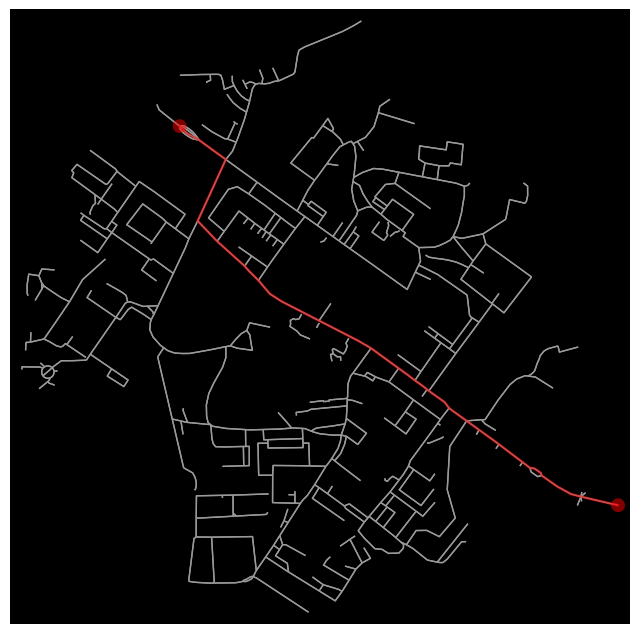

In [41]:
# 최단 경로 탐색
shortest_path = find_shortest_path(filtered_graph, origin_node, destination_node)

print(shortest_path)

# 최단 경로 시각화
plot_route(filtered_graph, shortest_path)

# 최단 경로의 가중치 합 계산 (길이 [단위 : m])
shortest_path_length = nx.shortest_path_length(filtered_graph, origin_node, destination_node, weight='length')

# 최단 경로를 거치는 모든 노드 수
num_nodes_in_path = len(shortest_path)

In [42]:
print("after")
# 필터링 후 캠퍼스 도로 네트워크 정보 출력
print(f"총 노드 수 : {len(filtered_graph.nodes(data=True))}")
print(f"총 경로 수 : {len(filtered_graph.edges(data=True))}")

# 필터링 후 최단 경로 정보 출력
print(f"최단 경로의 가중치 합 (길이): {shortest_path_length}m")
print(f"최단 경로에서 거치는 노드의 수: {num_nodes_in_path} 개")

after
총 노드 수 : 594
총 경로 수 : 1024
최단 경로의 가중치 합 (길이): 1267.9186393016284m
최단 경로에서 거치는 노드의 수: 31 개


## Thpt 활용하여 위의 과정 반복

- thpt dataset 불러오기

In [43]:
# 엑셀 comm data(throughput) 불러오기
pathloss_df = pd.read_excel('CommData_Node.xlsx')

# throughput 정보를 노드에 매핑
G_set_node = map_pathloss_to_nodes(filtered_graph,pathloss_df)

# 노드에 매핑된 throughput 정보를 평균내어 간선에 매핑
G_set_edge = set_edge_weights_based_on_pathloss(G_set_node)

# comm data가 들어간 최종적인 네트워크 graph생성
G_complete = G_set_edge


# # path를 다르게 출력하여 겸증하기 위한 임의로 가중치 조정
# modify_edge_weight(G_complete, 4727599724, 4402724105, 1000)

- 최강 신호 경로 탐색하기

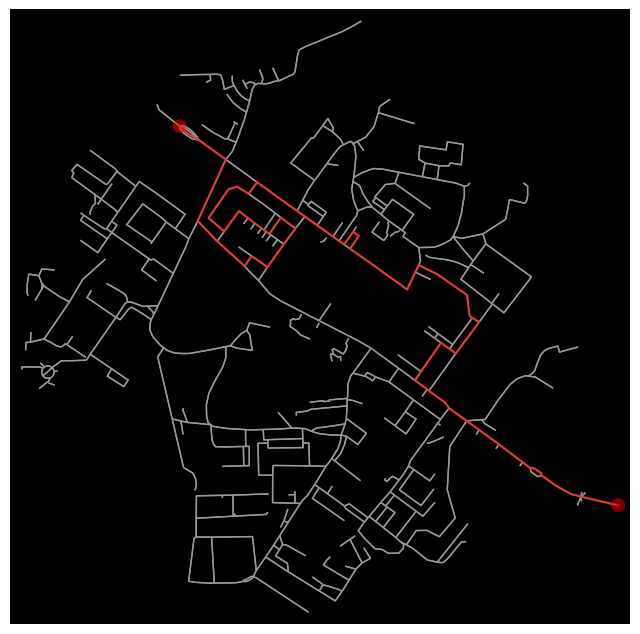

[4727599759, 4496854212, 4727599754, 4658272910, 4658272907, 4658272627, 4658272625, 4658272616, 4403766754, 4727599752, 4403766719, 4400580281, 4658272841, 4727599749, 4400580283, 4748297941, 4400580288, 4400580284, 4400580289, 4727599747, 4400580280, 4400580282, 4655491156, 4727599741, 4727599740, 4655491145, 4400580297, 8973274228, 4727599737, 4727599735, 4403782460, 4727599732, 4402717745, 4727599731, 4402717746, 4402717742, 4402717733, 4402717729, 4402724110, 4402717711, 4727599726, 4402724104, 4727599724, 4402724105, 4402724113, 4655492801, 4404203162, 4655492804, 4402724116, 4655492806, 4655492813, 4655492812, 4402724109, 4404203156, 4402727519, 4402727516, 4402727517, 4402727518, 4402727512, 3958352393, 4727599722, 3958352394, 4727599721, 4748296088, 4748296080]
0.00700018541172795
최단 경로에서 거치는 노드의 수: 31 개


In [44]:
# 최강 경로 탐색
strongest_path, avg_weight = find_strongest_path(G_complete, origin_node, destination_node)

# 최강 경로 시각화
plot_route(G_complete, strongest_path)



print(strongest_path)
print(avg_weight)

## 최단 경로를 거치는 모든 노드 수
num_nodes_in_path = len(shortest_path)

print(f"최단 경로에서 거치는 노드의 수: {num_nodes_in_path} 개")

In [45]:
# Folium 지도에 경로 표시
strongest_route_map = plot_route_on_map(G_complete, strongest_path)

strongest_route_map

NameError: name 'node' is not defined